In [ ]:


!apt-get install poppler-utils tesseract-ocr libmagic-dev


%pip install -Uq "unstructured[all-docs]" pillow lxml pillow
%pip install -Uq chromadb tiktoken
%pip install -Uq langchain langchain-community langchain_voyageai langchain-groq langchain-chroma
%pip install -Uq python_dotenv
%pip install -qU langchain-google-genai
%pip install datasets evaluate rouge_score bert_score


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  libmagic-dev poppler-utils tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 5 newly installed, 0 to remove and 18 not upgraded.
Need to get 5,107 kB of archives.
After this operation, 16.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libmagic-dev amd64 1:5.41-3ubuntu0.1 [105 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.6 [186 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 te

In [ ]:
import os
import time
import re
import uuid
import base64
from base64 import b64decode
from IPython.display import Image, display
from tenacity import retry, stop_after_attempt, wait_exponential

from unstructured.partition.pdf import partition_pdf

from langchain_voyageai import VoyageAIEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain.schema import StrOutputParser
from langchain_core.messages import SystemMessage, HumanMessage

from langchain_chroma import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.retrievers.multi_vector import MultiVectorRetriever

#eval
from datasets import Dataset
from sklearn.metrics import precision_score, recall_score
import evaluate
import numpy as np


In [ ]:
def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))


In [ ]:
os.environ["GOOGLE_API_KEY"] = "Put your API Key"
os.environ["GROQ_API_KEY"] = "Put your API Key"
os.environ["LANGCHAIN_API_KEY"] = "Put your API Key"
os.environ["LANGCHAIN_TRACING_V2"] = "True"



embeddings = VoyageAIEmbeddings(
    voyage_api_key="Put your API Key", model="voyage-3"
)


In [ ]:
# carefully check this pathes
output_path = '/content/processed_papers/'
file_path = '/content/attention_is_all_you_need.pdf'


In [ ]:
chunks = partition_pdf(
        filename=file_path,
        # Improved table handling
        infer_table_structure=True,
        strategy="hi_res",

        # Enhanced image and table extraction
        extract_image_block_types=["Image", "Table", "Figure"],
        image_output_dir_path=output_path,
        extract_image_block_to_payload=True,

        # More granular chunking controls
        chunking_strategy="by_title",
        max_characters=1500,              # Reduced for better context windows
        combine_text_under_n_chars=500,  # Better for maintaining coherent sections
        new_after_n_chars=1200,          # Balanced chunk size

        # Additional parameters
        include_page_breaks=True,
        include_metadata=True,
        paragraph_grouper=True,
        underlay_over_image=True,
    )


yolox_l0.05.onnx:   0%|          | 0.00/217M [00:00<?, ?B/s]

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

## Improving Extraction of Figure and Table Names for Evaluation  
### The code checks for a `caption` element or a `text` element next to the image or table, either below or above it in can handle also if the caption in another chunk (as shown in the tables in the paper).

In [ ]:

def extract_fig_table_name(text):
    """
    Extracts a figure or table name from text.
    This function will only match text that starts with, for example, 'Figure 1' or 'Fig. 1'.
    """
    # This pattern matches 'Figure 1' or 'Fig. 1' at the beginning of the text.
    pattern = re.compile(r'^(Figure|Fig|Table\.?)\s+(\d+)', re.IGNORECASE)
    match = pattern.match(text.strip())
    if match:
        # Return in a consistent lower-case format, e.g., "figure 1"
        return f"{match.group(1).lower()} {match.group(2)}"
    return None


def get_tables_and_texts(chunks):
    tables_data = []
    texts = []
    table_names = []

    for chunk_idx, chunk in enumerate(chunks):
        if "CompositeElement" in str(type(chunk)):
            texts.append(chunk)
            chunk_els = chunk.metadata.orig_elements

            for i, el in enumerate(chunk_els):
                if 'Table' in str(type(el)):


                    tables_data.append(el)


                    caption_found = False


                    for prev_idx in range(i-1, -1, -1):
                        prev_el = chunk_els[prev_idx]
                        if hasattr(prev_el, 'text') and prev_el.text:
                            table_name = extract_fig_table_name(prev_el.text)
                            if table_name and 'table' in table_name:
                                table_names.append(table_name)
                                caption_found = True
                                break
                        if "Table" in str(type(prev_el)) or "Image" in str(type(prev_el)):
                            break


                    if not caption_found:
                        for next_idx in range(i+1, len(chunk_els)):
                            next_el = chunk_els[next_idx]
                            if hasattr(next_el, 'text') and next_el.text:
                                table_name = extract_fig_table_name(next_el.text)
                                if table_name and 'table' in table_name:
                                    table_names.append(table_name)
                                    caption_found = True
                                    break
                            if "Table" in str(type(next_el)) or "Image" in str(type(next_el)):
                                break


                    if not caption_found and chunk_idx > 0:
                        prev_chunk = chunks[chunk_idx - 1]
                        if "CompositeElement" in str(type(prev_chunk)):
                            for prev_el in prev_chunk.metadata.orig_elements:
                                if hasattr(prev_el, 'text') and prev_el.text:
                                    table_name = extract_fig_table_name(prev_el.text)
                                    if table_name and 'table' in table_name:
                                        table_names.append(table_name)
                                        caption_found = True
                                        break
                                if "Table" in str(type(prev_el)) or "Image" in str(type(prev_el)):
                                    break


                    if not caption_found and chunk_idx + 1 < len(chunks):
                        next_chunk = chunks[chunk_idx + 1]
                        if "CompositeElement" in str(type(next_chunk)):
                            for next_el in next_chunk.metadata.orig_elements:
                                if hasattr(next_el, 'text') and next_el.text:
                                    table_name = extract_fig_table_name(next_el.text)
                                    if table_name and 'table' in table_name:
                                        table_names.append(table_name)
                                        caption_found = True
                                        break
                                if "Table" in str(type(next_el)) or "Image" in str(type(next_el)):
                                    break


                    if not caption_found:
                        table_names.append(None)

    return tables_data, texts, table_names


def get_images_with_names(chunks):
    images_b64 = []
    image_names = []

    for chunk_idx, chunk in enumerate(chunks):
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements

            for i, el in enumerate(chunk_els):
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)

                    caption_found = False


                    for next_idx in range(i+1, len(chunk_els)):
                        next_el = chunk_els[next_idx]
                        if hasattr(next_el, 'text') and next_el.text:

                            fig_name = extract_fig_table_name(next_el.text)
                            if fig_name:
                                image_names.append(fig_name)
                                caption_found = True
                                break

                    if not caption_found and chunk_idx + 1 < len(chunks):
                        next_chunk = chunks[chunk_idx + 1]
                        if "CompositeElement" in str(type(next_chunk)):
                            for next_el in next_chunk.metadata.orig_elements:
                                if hasattr(next_el, 'text') and next_el.text:
                                    fig_name = extract_fig_table_name(next_el.text)
                                    if fig_name:
                                        image_names.append(fig_name)
                                        caption_found = True
                                        break

                    if not caption_found:
                        image_names.append(None)

    return images_b64, image_names

# Usage:
tables, texts, table_names = get_tables_and_texts(chunks)
images, image_names = get_images_with_names(chunks)

# Print results to verify
print("Tables found:", len(tables))
print("Table names:", table_names)
print("\nImages found:", len(images))
print("Image names:", image_names)

Tables found: 4
Table names: ['table 1', 'table 2', 'table 3', 'table 4']

Images found: 7
Image names: ['figure 1', 'figure 2', 'figure 2', 'figure 3', 'figure 4', 'figure 5', 'figure 5']


In [ ]:
#handling text and tables (llama-3.2 used)
prompt_text = """
You are a precise summarization assistant. Provide a clear, information-dense summary of the following {element}:

[TABLE/TEXT]

Requirements:
- Focus on key insights and main points
- Use concise, direct language
- Maintain essential numerical data and relationships
- Preserve the original meaning and context
- Maximum length: 3-4 sentences
- Exclude phrases like "This is a summary" or meta-commentary

"""

prompt = ChatPromptTemplate.from_template(prompt_text)

model = ChatGroq(model='llama-3.2-11b-vision-preview')
summarize_chain = prompt | model | StrOutputParser()


In [ ]:
text_summaries = []
for text in texts:
    summary = summarize_chain.invoke(text)
    text_summaries.append(summary)
    time.sleep(10) #for limit rate

In [ ]:
table_summaries = []
for table in tabels:
    table_html = table.metadata.text_as_html
    summary = summarize_chain.invoke(table_html)
    table_summaries.append(summary)
    time.sleep(15) #for limit rate

In [ ]:
# For handling images summaries (Gemini 2 flash used)

# Initialize model (switch back to Gemini for vision)
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")

# Prompt template
PROMPT_TEMPLATE = """
Analyze this research image from a transformer architecture paper. Include:

- Type of visual (diagram, graph, chart, etc.)
- All text labels and annotations
- Specific values and relationships shown in plots/graphs
- Color schemes and visual elements used
- Mathematical formulas or equations if present
- Direction of data flow and connections between components
- Key architectural elements and their relationships
- Scale, units, and axes details for any plots
- Legend information and what different symbols represent

Focus on precise technical details rather than general descriptions. Maintain academic language consistent with transformer research papers.

Image: {image}
don't say anything only the analysis
the analysis should be short 10~15 sentences at most
"""

@retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=4, max=10))
def process_image(image_base64):
    # Create message with direct image embedding
    message = HumanMessage(content=[
        {"type": "text", "text": PROMPT_TEMPLATE},
        {"type": "image_url", "image_url": f"data:image/jpeg;base64,{image_base64}"}
    ])

    # Get response and parse
    response = llm.invoke([message])
    return StrOutputParser().parse(response)

# Process images with error handling
image_summaries = []
for img in images:
    try:
        summary = process_image(img)
        image_summaries.append(summary)
        time.sleep(3)
    except Exception as e:
        print(f"Failed to process image: {str(e)}")
        image_summaries.append("Description unavailable")

image_summaries[0]

image_summaries = [img.content for img in image_summaries]

In [ ]:
#creating our MultiVector store which consist of VectorDataBase for the summaries and DocStore for the texts-tables-images
vectorstore = Chroma(collection_name='sorour_rag',embedding_function=embeddings)
doc_store = InMemoryStore()

id_key = 'doc_id'

retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=doc_store,
    id_key=id_key,
)


In [ ]:

# Generate unique doc_ids for each text
doc_ids = [str(uuid.uuid4()) for _ in texts]

# Initialize an empty list for summary_texts
summary_texts = []

# Process and add documents one by one
for i, (text, summary) in enumerate(zip(texts, text_summaries)):
    # Create the Document object
    doc = Document(
        page_content=summary,
        metadata={id_key: doc_ids[i]}
    )

    # Add the document to the vectorstore
    retriever.vectorstore.add_documents([doc])

    # Add the document to the docstore one by one
    retriever.docstore.mset([(doc_ids[i], text)])

    # Add a delay to avoid rate limits or embedding errors
    time.sleep(21) # you can use BGE/M3(Multilingual) model or Snowflake/snowflake-arctic-embed-l-v2.0(MultiLignual) can work on colab


    # Optional: Print progress
    print(f"Processed document {i + 1}/{len(texts)}")


Processed document 1/37
Processed document 2/37
Processed document 3/37
Processed document 4/37
Processed document 5/37
Processed document 6/37
Processed document 7/37
Processed document 8/37
Processed document 9/37
Processed document 10/37
Processed document 11/37
Processed document 12/37
Processed document 13/37
Processed document 14/37
Processed document 15/37
Processed document 16/37
Processed document 17/37
Processed document 18/37
Processed document 19/37
Processed document 20/37
Processed document 21/37
Processed document 22/37
Processed document 23/37
Processed document 24/37
Processed document 25/37
Processed document 26/37
Processed document 27/37
Processed document 28/37
Processed document 29/37
Processed document 30/37
Processed document 31/37
Processed document 32/37
Processed document 33/37
Processed document 34/37
Processed document 35/37
Processed document 36/37
Processed document 37/37


In [ ]:

#time.sleep(30)
table_ids = [str(uuid.uuid4()) for _ in tabels]
summary_tables = [
    Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tabels)))





In [ ]:
#time.sleep(30)
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

In [ ]:
docs = retriever.invoke(
    "how is the scaled dot product attention calculated?"
)

In [ ]:
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

3.2 Attention

An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum

3

Scaled Dot-Product Attention Multi-Head Attention

Linear

Figure 2: (left) Scaled Dot-Product Attention. (right) Multi-Head Attention consists of several attention layers running in parallel.

of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

--------------------------------------------------------------------------------
3.2.1 Scaled Dot-Product Attention

We call our particular attention "Scaled Dot-Product Attention" (Figure 2). The input consists of queries and keys of dimension dk, and values of dimension dv. We compute the dot products of the √ dk, and apply a softmax function to obtain the weights on the query with all keys, divide each by values.

In practice, we compute the 

In [ ]:
# Prepare the prompt for the LLM

# Distinguish between different kinds of modal texts (text-tables), image
def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )



In [ ]:
# This for just get the response
chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | llm
    | StrOutputParser()
)

# This for get the response and the retrieved docs(see below)
chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | llm
        | StrOutputParser()
    )
)

In [ ]:
response = chain_with_sources.invoke(
    "How is the scaled dot product attetion calculated")



In [ ]:
response

{'context': {'images': [],
  'texts': [<unstructured.documents.elements.CompositeElement at 0x7878b3c0fbd0>,
   <unstructured.documents.elements.CompositeElement at 0x7878b3e1f3d0>]},
 'question': 'How is the scaled dot product attetion calculated',
 'response': 'The scaled dot-product attention is calculated using the formula:\n\nAttention(Q, K, V ) = softmax( QK^T / √dk )V'}

In [ ]:
response['response']

'The scaled dot-product attention is calculated using the formula:\n\nAttention(Q, K, V ) = softmax( QK<sup>T</sup> / √d<sub>k</sub> )V'

In [ ]:
print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

Response: The scaled dot-product attention is calculated using the formula:

Attention(Q, K, V ) = softmax( QK^T / √dk )V


Context:
3.2.1 Scaled Dot-Product Attention

We call our particular attention "Scaled Dot-Product Attention" (Figure 2). The input consists of queries and keys of dimension dk, and values of dimension dv. We compute the dot products of the √ dk, and apply a softmax function to obtain the weights on the query with all keys, divide each by values.

In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix Q. The keys and values are also packed together into matrices K and V . We compute the matrix of outputs as:

Attention(Q, K, V ) = softmax( QK T √ dk )V (1)

The two most commonly used attention functions are additive attention [2], and dot-product (multi- plicative) attention. Dot-product attention is identical to our algorithm, except for the scaling factor 1√ of . Additive attention computes the compatibili

In [ ]:
# Load Hugging Face metrics
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

# Evaluation dataset
evaluation_dataset = [
    {
      "query": "What is the main contribution of the Transformer model?",
      "relevant_context": "We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely.",
      "reference_answer": "The Transformer model introduces a novel architecture based entirely on self-attention mechanisms, removing the need for recurrence and convolutions.",
      "page_number": 1,
      "modality": "text"
    },
    {
      "query": "What does Figure 1 in the paper illustrate?",
      "relevant_context": "Figure 1: The Transformer - model architecture.",
      "reference_answer": "Figure 1 illustrates the overall architecture of the Transformer model, showing the encoder and decoder stacks based on self-attention and feed-forward layers.",
      "page_number": 3,
      "modality": "image"
    },
    {
      "query": "What is the role of positional encoding in the Transformer?",
      "relevant_context": "Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence.",
      "reference_answer": "Positional encoding provides information about token order since the Transformer lacks recurrence and convolutions.",
      "page_number": 6,
      "modality": "text"
    },
    {
      "query": "What are the three main ways the Transformer uses attention?",
      "relevant_context": "The Transformer uses multi-head attention in three different ways: (1) Encoder-decoder attention, where queries come from the decoder and keys/values from the encoder, (2) Self-attention in the encoder, where each position attends to all positions, and (3) Self-attention in the decoder, where each position attends only to previous positions.",
      "reference_answer": "The Transformer employs multi-head attention in three ways: encoder-decoder attention, encoder self-attention, and decoder self-attention.",
      "page_number": 5,
      "modality": "text"
    },
    {
      "query": "What training dataset was used for the WMT 2014 English-German task?",
      "relevant_context": "We trained on the standard WMT 2014 English-German dataset consisting of about 4.5 million sentence pairs.",
      "reference_answer": "The WMT 2014 English-German dataset, which contains approximately 4.5 million sentence pairs, was used for training.",
      "page_number": 7,
      "modality": "text"
    }
]

# Evaluation results storage
retrieval_results = []
generation_results = []

# Run evaluation
for sample in evaluation_dataset:
    try:
        # Run RAG pipeline
        result = chain_with_sources.invoke(sample["query"])
        time.sleep(65)
        # Extract text content from the retrieved context
        retrieved_context = " ".join([str(text) for text in result["context"]["texts"]])
        generated_answer = result["response"]

        # Skip empty results
        if not retrieved_context.strip():
            print(f"Warning: Empty retrieved context for query: {sample['query']}")
            continue

        # ----- Retrieval Evaluation -----
        retrieved_context_set = set(retrieved_context.lower().split())  # Token-level matching
        ground_truth_context_set = set(sample["relevant_context"].lower().split())

        intersection = len(retrieved_context_set & ground_truth_context_set)
        precision = intersection / len(retrieved_context_set) if retrieved_context_set else 0
        recall = intersection / len(ground_truth_context_set) if ground_truth_context_set else 0

        retrieval_results.append({"precision": precision, "recall": recall})

        # ----- Generation Evaluation -----
        references = [sample["reference_answer"]]
        predictions = [generated_answer]

        bleu_score = bleu.compute(predictions=predictions, references=references)["bleu"]
        rouge_score = rouge.compute(predictions=predictions, references=references)["rougeL"]
        bert_score = bertscore.compute(predictions=predictions, references=references, lang="en")["f1"]

        generation_results.append({
            "bleu": bleu_score,
            "rouge": rouge_score,
            "bert_score": np.mean(bert_score)  # Averaging F1 scores over tokens
        })

    except Exception as e:
        print(f"Error processing query: {sample['query']}")
        print(f"Error details: {str(e)}")
        continue

# ----- Compute Overall Metrics -----
if retrieval_results:
    avg_precision = np.mean([r["precision"] for r in retrieval_results])
    avg_recall = np.mean([r["recall"] for r in retrieval_results])

    avg_bleu = np.mean([g["bleu"] for g in generation_results])
    avg_rouge = np.mean([g["rouge"] for g in generation_results])
    avg_bert_score = np.mean([g["bert_score"] for g in generation_results])

    print("\nOverall Evaluation Results:")
    print(f"Retrieval Evaluation -> Precision@k: {avg_precision:.4f}, Recall@k: {avg_recall:.4f}")
    print(f"Generation Evaluation -> BLEU: {avg_bleu:.4f}, ROUGE-L: {avg_rouge:.4f}, BERTScore: {avg_bert_score:.4f}")
else:
    print("No valid evaluation results were generated.")

# Optional: Detailed results per query
print("\nDetailed Results per Query:")
for i, sample in enumerate(evaluation_dataset):
    if i < len(retrieval_results):
        print(f"\nQuery: {sample['query']}")
        print(f"Retrieval Metrics -> Precision: {retrieval_results[i]['precision']:.4f}, Recall: {retrieval_results[i]['recall']:.4f}")
        print(f"Generation Metrics -> BLEU: {generation_results[i]['bleu']:.4f}, ROUGE-L: {generation_results[i]['rouge']:.4f}, BERTScore: {generation_results[i]['bert_score']:.4f}")



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Overall Evaluation Results:
Retrieval Evaluation -> Precision@k: 0.0840, Recall@k: 0.9394
Generation Evaluation -> BLEU: 0.0973, ROUGE-L: 0.3890, BERTScore: 0.9162

Detailed Results per Query:

Query: What is the main contribution of the Transformer model?
Retrieval Metrics -> Precision: 0.0803, Recall: 1.0000
Generation Metrics -> BLEU: 0.0000, ROUGE-L: 0.3380, BERTScore: 0.9253

Query: What does Figure 1 in the paper illustrate?
Retrieval Metrics -> Precision: 0.1510, Recall: 1.0000
Generation Metrics -> BLEU: 0.0000, ROUGE-L: 0.2174, BERTScore: 0.8984

Query: What is the role of positional encoding in the Transformer?
Retrieval Metrics -> Precision: 0.0649, Recall: 0.7576
Generation Metrics -> BLEU: 0.0411, ROUGE-L: 0.3178, BERTScore: 0.8830

Query: What are the three main ways the Transformer uses attention?
Retrieval Metrics -> Precision: 0.0396, Recall: 1.0000
Generation Metrics -> BLEU: 0.3480, ROUGE-L: 0.6829, BERTScore: 0.9580


# MultiModal Evaluation

In [ ]:
vectorstore = Chroma(collection_name='MME',embedding_function=embeddings)
doc_store = InMemoryStore()

id_key = 'doc_id'

retriever_multimodal = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=doc_store,
    id_key=id_key,
)


In [ ]:
table_ids = [str(uuid.uuid4()) for _ in tables]
for i, summary in enumerate(table_summaries):
    if table_names[i] is not None:
        metadata = {
            id_key: table_ids[i],
            "table_name": table_names[i]
        }
    else:
        metadata = {
            id_key: table_ids[i],
        }

    time.sleep(20)

    # Create the Document for the vectorstore
    doc = Document(page_content=summary, metadata=metadata)
    retriever_multimodal.vectorstore.add_documents([doc])
    print(f"Added document {i} to vectorstore.")

    # Create a combined dictionary to store in the docstore
    # that includes both table and metadata
    doc_data = {
        "table": tables[i],
        "metadata": metadata
    }

    # Add the combined document to the docstore with its unique id
    retriever_multimodal.docstore.mset([(table_ids[i], doc_data)])
    print(f"Stored table and metadata for document {i} in docstore.")



img_ids = [str(uuid.uuid4()) for _ in images]
for i, summary in enumerate(image_summaries):
    if image_names[i] is not None:
        metadata = {
            id_key: img_ids[i],
            "figure_name": image_names[i]
        }
    else:
        metadata = {
            id_key: img_ids[i],
        }

    time.sleep(20)

    # Create the Document for the vectorstore
    doc = Document(page_content=summary, metadata=metadata)
    retriever_multimodal.vectorstore.add_documents([doc])
    print(f"Added document {i} to vectorstore.")

    # Create a combined dictionary to store in the docstore
    # that includes both image and metadata
    doc_data = {
        "image": images[i],
        "metadata": metadata
    }

    # Add the combined document to the docstore with its unique id
    retriever_multimodal.docstore.mset([(img_ids[i], doc_data)])
    print(f"Stored image and metadata for document {i} in docstore.")



Added document 0 to vectorstore.
Stored table and metadata for document 0 in docstore.
Added document 1 to vectorstore.
Stored table and metadata for document 1 in docstore.
Added document 2 to vectorstore.
Stored table and metadata for document 2 in docstore.
Added document 3 to vectorstore.
Stored table and metadata for document 3 in docstore.
Added document 0 to vectorstore.
Stored image and metadata for document 0 in docstore.
Added document 1 to vectorstore.
Stored image and metadata for document 1 in docstore.
Added document 2 to vectorstore.
Stored image and metadata for document 2 in docstore.
Added document 3 to vectorstore.
Stored image and metadata for document 3 in docstore.
Added document 4 to vectorstore.
Stored image and metadata for document 4 in docstore.
Added document 5 to vectorstore.
Stored image and metadata for document 5 in docstore.
Added document 6 to vectorstore.
Stored image and metadata for document 6 in docstore.


In [ ]:

# Generate unique doc_ids for each text
doc_ids = [str(uuid.uuid4()) for _ in texts]

# Initialize an empty list for summary_texts
summary_texts = []

# Process and add documents one by one
for i, (text, summary) in enumerate(zip(texts, text_summaries)):
    # Create the Document object
    doc = Document(
        page_content=summary,
        metadata={id_key: doc_ids[i]}
    )

    # Add the document to the vectorstore
    retriever_multimodal.vectorstore.add_documents([doc])

    # Add the document to the docstore one by one
    retriever_multimodal.docstore.mset([(doc_ids[i], text)])

    # Add a delay to avoid rate limits or embedding errors
    time.sleep(21)  # Adjust the delay as needed


    # Optional: Print progress
    print(f"Processed document {i + 1}/{len(texts)}")


Processed document 1/37
Processed document 2/37
Processed document 3/37
Processed document 4/37
Processed document 5/37
Processed document 6/37
Processed document 7/37
Processed document 8/37
Processed document 9/37
Processed document 10/37
Processed document 11/37
Processed document 12/37
Processed document 13/37
Processed document 14/37
Processed document 15/37
Processed document 16/37
Processed document 17/37
Processed document 18/37
Processed document 19/37
Processed document 20/37
Processed document 21/37
Processed document 22/37
Processed document 23/37
Processed document 24/37
Processed document 25/37
Processed document 26/37
Processed document 27/37
Processed document 28/37
Processed document 29/37
Processed document 30/37
Processed document 31/37
Processed document 32/37
Processed document 33/37
Processed document 34/37
Processed document 35/37
Processed document 36/37
Processed document 37/37


In [ ]:
# First fix the dataset syntax (added missing comma and fixed name)
multimodal_evaluation_dataset = [
    {
        "query": "Show me the that shows the difference between Scaled Dot-Product Attention and Multi-Head Attention",
        "answer": 'figure 2',
        'modality': 'image'
    },
    {
        "query": "What's ByteNet performance in BLUE EN-DE",
        "answer": "table 2",
        "modality": "table"
    },
    {
        "query": "The green Attention connections",  # Fixed missing comma here
        "answer": "figure 5",
        "modality": "image",
    },
    {
        "query": "what are the parser used in the paper",
        "answer": "table 4",
        "modality": "table"
    },
]

def evaluate_retriever(retriever, dataset):
    correct = 0
    total = len(dataset)
    results = []

    for case in dataset:
        time.sleep(20)
        query = case["query"]
        expected_answer = case["answer"]
        modality = case["modality"]

        # Get retrieval results
        response = retriever.invoke(query)

        if not response:
            results.append({
                "query": query,
                "expected": expected_answer,
                "retrieved": None,
                "match": False
            })
            continue

        # Get top result's metadata
        top_result = response[0]['metadata']

        # Determine which key to check based on modality
        metadata_key = 'table_name' if modality == 'table' else 'figure_name'
        retrieved_answer = top_result.get(metadata_key, None)

        # Check match
        is_correct = retrieved_answer == expected_answer
        if is_correct:
            correct += 1

        results.append({
            "query": query,
            "expected": expected_answer,
            "retrieved": retrieved_answer,
            "match": is_correct
        })

    accuracy = correct / total if total > 0 else 0
    return {
        "accuracy": accuracy,
        "total": total,
        "correct": correct,
        "detailed_results": results
    }

# Usage
evaluation_results = evaluate_retriever(retriever_multimodal, multimodal_evaluation_dataset)

# Print results
print(f"Accuracy: {evaluation_results['accuracy']:.2f} ({evaluation_results['correct']}/{evaluation_results['total']})")
print("\nDetailed Results:")
for result in evaluation_results['detailed_results']:
    print(f"Query: {result['query']}")
    print(f"Expected: {result['expected']}")
    print(f"Retrieved: {result['retrieved']}")
    print(f"Match: {'✅' if result['match'] else '❌'}")
    print("-" * 50)

Accuracy: 1.00 (4/4)

Detailed Results:
Query: Show me the that shows the difference between Scaled Dot-Product Attention and Multi-Head Attention
Expected: figure 2
Retrieved: figure 2
Match: ✅
--------------------------------------------------
Query: What's ByteNet performance in BLUE EN-DE
Expected: table 2
Retrieved: table 2
Match: ✅
--------------------------------------------------
Query: The green Attention connections
Expected: figure 5
Retrieved: figure 5
Match: ✅
--------------------------------------------------
Query: what are the parser used in the paper
Expected: table 4
Retrieved: table 4
Match: ✅
--------------------------------------------------


In [ ]:
reponse = chain_with_sources.invoke("How is the scaled dot product attetion calculated")

In [ ]:
response['response']

'The scaled dot-product attention is calculated using the formula:\n\nAttention(Q, K, V ) = softmax( QK^T / √dk )V'

In [ ]:
response = chain_with_sources.invoke("what is the BLEU score of the model in English to German translation EN-DE")

In [ ]:
reponse['response']

'Based on Table 2, the BLEU score of the Transformer (base model) in English to German translation (EN-DE) is 27.3.'

In [ ]:
response = chain_with_sources.invoke("How Long were the base and big models trained?")

In [ ]:
response['response']

'The base models were trained for 100,000 steps or 12 hours, and the big models were trained for 300,000 steps (3.5 days).'

In [ ]:
response = chain_with_sources.invoke("Which optimizer was used when training the models?")

In [ ]:
response['response']

'The Adam optimizer was used when training the models.'

In [ ]:
response = chain_with_sources.invoke("Show me a pictyre that shows the difference between Scaled Dot-Product Attention and Multi-Head Attention")

Here's the image showing the difference between Scaled Dot-Product Attention and Multi-Head Attention:


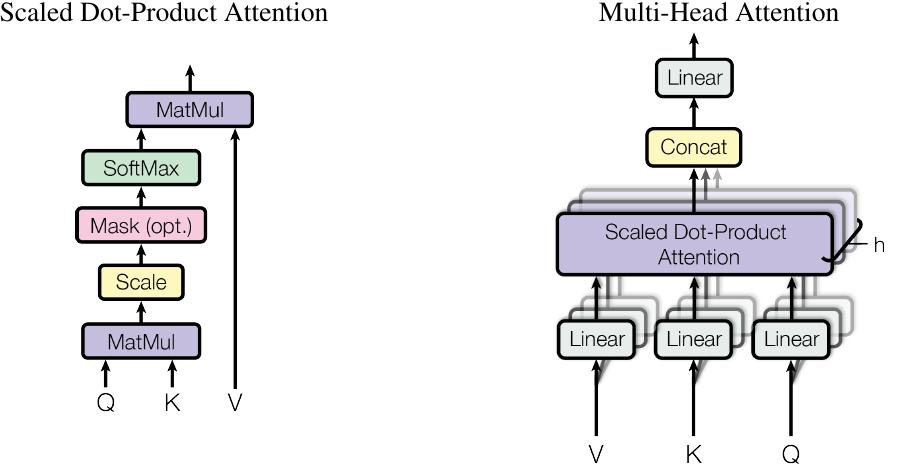

In [ ]:
print(response['response'])
display_base64_image(response['context']['images'][0])